<a href="https://colab.research.google.com/github/ariaanthor/Medical-Imaging-to-Detect-Pneumonia/blob/main/Pneumonia_Detection_Medical_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run to load data and helper functions
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
import gdown
from ipywidgets import interact, IntSlider

IMG_PATH = "reduced/imgs"
MASK_PATH = "reduced/masks"
EPOCHS = 40

gdown.download("https://drive.google.com/uc?id=1_2UHVdkeuCHwwcb2RGs0cosNw8l_YoAE", "reduced.zip", True)
!unzip -oq reduced.zip

np.random.seed(12)
tf.random.set_seed(12)

def load():
    imgs_paths = sorted([Path(IMG_PATH) / p for p in os.listdir(IMG_PATH)])
    masks_paths = sorted([Path(MASK_PATH) / p for p in os.listdir(MASK_PATH)])
    imgs = [plt.imread(p) for p in imgs_paths]
    masks = [plt.imread(p)[:, :, 0][:, :, None] > 0.5 for p in masks_paths]
    imgs, masks = np.array(imgs)[:,:,:,0:1], np.array(masks).astype(float)
    imgs_train, imgs_test, masks_train, masks_test = train_test_split(
        imgs, masks, test_size=0.2, shuffle=False
    )
    return imgs_train, imgs_test, masks_train, masks_test

def show_lung_mask_sbs(lung, mask):
    fig, (a1, a2) = plt.subplots(1, 2)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")


def show_lung_mask_pred_sbs(lung, mask, pred):
    fig, (a1, a2, a3) = plt.subplots(1, 3)
    a1.imshow(lung.squeeze(), cmap = 'gray')
    a2.imshow(mask.squeeze(), cmap = 'gray')
    a3.imshow(pred.squeeze(), cmap = 'gray')
    a1.set_title("lung")
    a2.set_title("mask")
    a3.set_title("predicted mask")

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator

class ShowLearning(tf.keras.callbacks.Callback):
    def __init__(self, data, masks, name):
        self.data = data
        self.masks = masks
        self.fig_path = f"lung/figs/{name}"
        if not os.path.exists(self.fig_path):
            os.makedirs(self.fig_path)
        super().__init__()

    def on_epoch_begin(self, epoch, logs=None):
        rand_index = np.random.randint(0, len(self.data))
        rand_img = self.data[rand_index][None, :, :, :]
        mask = self.masks[rand_index][None, :, :, :]
        preds = self.model(rand_img).numpy() > 0.5
        show_lung_mask_pred_sbs(rand_img, mask, preds)
        plt.savefig(f"{self.fig_path}/epoch{epoch}.png")
        plt.close()

def show_training_image(name, epoch):
  im = plt.imread(f'lung/figs/{name}/epoch{epoch}.png')
  plt.imshow(im)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1, 2, 3))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(1, 2, 3))
    return 1 - numerator / denominator


In [ ]:
imgs_train, imgs_test, masks_train, masks_test = load()
print(imgs_train.shape, imgs_test.shape, masks_train.shape, masks_test.shape)

(213, 64, 64, 1) (54, 64, 64, 1) (213, 64, 64, 1) (54, 64, 64, 1)


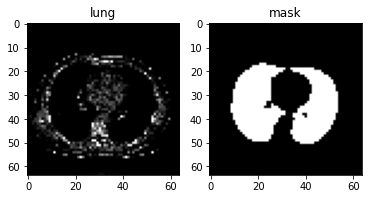

In [ ]:
img_num = 20
show_lung_mask_sbs(imgs_train[img_num], masks_train[img_num])

In [ ]:
def SimpleConvModel():
    model = tf.keras.models.Sequential(
        [
Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation='relu'),
Conv2D(filters = 32, kernel_size = 3, strides = 1, padding='same', activation='relu'),
Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='same', activation='relu'),
            Conv2D(filters = 1, kernel_size = 3, strides = 1, padding="same", activation="sigmoid"),
        ]
    ) 
    return model

model = SimpleConvModel()

In [ ]:
def train(model, imgs, masks, loss, name, epochs):
    optimizer = tf.optimizers.Adam(learning_rate=0.0003)
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=["accuracy"],
    )
    model.fit(
        imgs,
        masks,
        epochs=epochs,
        callbacks=[ShowLearning(imgs, masks, name)],
    )

train(model, imgs_train, masks_train, tf.losses.BinaryCrossentropy(), 'simple_conv', EPOCHS)

Epoch 1/40
7/7 [==============================] - 0s 6ms/step - loss: 0.6840 - accuracy: 0.7393
Epoch 2/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6670 - accuracy: 0.7662
Epoch 3/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6469 - accuracy: 0.7662
Epoch 4/40
7/7 [==============================] - 0s 6ms/step - loss: 0.6224 - accuracy: 0.7662
Epoch 5/40
7/7 [==============================] - 0s 5ms/step - loss: 0.5948 - accuracy: 0.7662
Epoch 6/40
7/7 [==============================] - 0s 5ms/step - loss: 0.5684 - accuracy: 0.7662
Epoch 7/40
7/7 [==============================] - 0s 5ms/step - loss: 0.5501 - accuracy: 0.7662
Epoch 8/40
7/7 [==============================] - 0s 5ms/step - loss: 0.5452 - accuracy: 0.7662
Epoch 9/40
7/7 [==============================] - 0s 5ms/step - loss: 0.5431 - accuracy: 0.7662
Epoch 10/40
7/7 [==============================] - 0s 6ms/step - loss: 0.5392 - accuracy: 0.7662
Epoch 11/40
7/7 [======================

In [ ]:
output_shape_guess = (None, 64, 64, 1)
assert model.output_shape == output_shape_guess
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 16)        4624      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 1)         145       
Total params: 9,569
Trainable params: 9,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
interact(lambda epoch: show_training_image('simple_conv', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [ ]:
(masks_train.sum()/ masks_train.size) * 100

23.375605193661972

In [ ]:
def dice(true_mask, predicted_mask):
    true_mask, predicted_mask = true_mask.astype(bool).flatten(), predicted_mask.astype(bool).flatten()
    return (2*(sum(true_mask & predicted_mask)) / (sum(true_mask) + sum(predicted_mask)))

Dice score: 0.41117145073700545


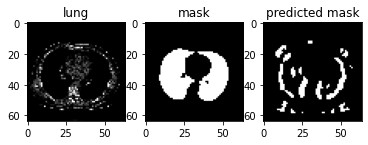

In [ ]:
img_num = 20

img = np.expand_dims(imgs_train[img_num],0)
true_mask = masks_train[img_num]
pred_mask = model.predict(img) > 0.5

show_lung_mask_pred_sbs(img, true_mask, pred_mask)

print("Dice score:", dice(true_mask, pred_mask))

In [ ]:
model_with_dice = SimpleConvModel()
train(model_with_dice, imgs_train, masks_train, dice_loss, 'simple_conv_with_dice', EPOCHS)

Epoch 1/40
7/7 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.3819
Epoch 2/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6848 - accuracy: 0.2638
Epoch 3/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6828 - accuracy: 0.2393
Epoch 4/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6799 - accuracy: 0.2346
Epoch 5/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.2339
Epoch 6/40
7/7 [==============================] - 0s 6ms/step - loss: 0.6689 - accuracy: 0.2338
Epoch 7/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6600 - accuracy: 0.2338
Epoch 8/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6484 - accuracy: 0.2338
Epoch 9/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6359 - accuracy: 0.2340
Epoch 10/40
7/7 [==============================] - 0s 5ms/step - loss: 0.6243 - accuracy: 0.2376
Epoch 11/40
7/7 [======================

In [ ]:
interact(lambda epoch: show_training_image('simple_conv_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [ ]:
def section(c1, c2):
    return tf.keras.Sequential(
        [
            Conv2D(c1, 3, padding="same", activation="relu"),
            Conv2D(c2, 3, padding="same", activation="relu"),
        ]
    )

class U_Net(tf.keras.Model):
    def __init__(self):
        super(U_Net, self).__init__()
        self.s1 = section(16, 16)
        self.s2 = section(32, 32)
        self.s3 = section(32, 64)
        self.s4 = section(32, 32)
        self.s5 = section(16, 16)
        self.final_conv = Conv2D(1, 3, padding="same", activation="sigmoid")
        self.m1, self.m2 = MaxPool2D(2), MaxPool2D(2)
        self.u1, self.u2 = UpSampling2D(2), UpSampling2D(2)

    def call(self, inputs):
        i1 = self.s1(inputs)
        i2 = self.s2(self.m1(i1))
        i3 = self.s3(self.m2(i2))
        i4 = self.s4(concatenate([i2, self.u1(i3)]))
        i5 = self.s5(concatenate([i1, self.u2(i4)]))
        x = self.final_conv(i5)
        return x

In [ ]:
unet = U_Net()

In [ ]:
train(unet, imgs_train, masks_train, dice_loss, 'unet_with_dice', epochs=EPOCHS)

Epoch 1/40
7/7 [==============================] - 0s 24ms/step - loss: 0.6864 - accuracy: 0.4589
Epoch 2/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6853 - accuracy: 0.3061
Epoch 3/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6796 - accuracy: 0.2393
Epoch 4/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6484 - accuracy: 0.2340
Epoch 5/40
7/7 [==============================] - 0s 9ms/step - loss: 0.6047 - accuracy: 0.2339
Epoch 6/40
7/7 [==============================] - 0s 10ms/step - loss: 0.6028 - accuracy: 0.2396
Epoch 7/40
7/7 [==============================] - 0s 10ms/step - loss: 0.5822 - accuracy: 0.3248
Epoch 8/40
7/7 [==============================] - 0s 10ms/step - loss: 0.5332 - accuracy: 0.5272
Epoch 9/40
7/7 [==============================] - 0s 9ms/step - loss: 0.4596 - accuracy: 0.6976
Epoch 10/40
7/7 [==============================] - 0s 11ms/step - loss: 0.3371 - accuracy: 0.8798
Epoch 11/40
7/7 [==============

In [ ]:
interact(lambda epoch: show_training_image('unet_with_dice', epoch), epoch=(0, EPOCHS-1));

interactive(children=(IntSlider(value=19, description='epoch', max=39), Output()), _dom_classes=('widget-inter…

In [ ]:
thresh = 0.5
preds = unet(imgs_test).numpy()
preds = preds >= thresh

def show_preds_helper(imgs_test, masks_test, preds, ind):
    show_lung_mask_pred_sbs(imgs_test[ind], masks_test[ind], preds[ind])
    plt.show()

interact(lambda i: show_preds_helper(imgs_test, masks_test, preds, i), i=(0, len(preds)-1));

interactive(children=(IntSlider(value=26, description='i', max=53), Output()), _dom_classes=('widget-interact'…

[Dataset](https://www.kaggle.com/kmader/finding-lungs-in-ct-data/data?select=lung_stats.csv) used in training